# Notebook for creating the TfIdf Embeddings of the Story feature

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Project/KickLearning/

/content/drive/.shortcut-targets-by-id/1iWelwZQ6yutjZacqvhb1xSPIvi_nlIiH/Project/KickLearning


Lybraries

In [3]:
from os.path import join

import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from time import time


import sklearn

import re

import pandas as pd
from sklearn.svm import SVR
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from os.path import join
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from __future__ import print_function
import sklearn
import re

### Loading the Dataset

In [4]:
data_path = join(".", "data")
destination_path = join(".", "data", "texts_embedded")

In [5]:
data = pd.read_csv(join(data_path, "final_dataset.csv"))
data = data[data['state'].isin(['successful', 'failed'])]

In [6]:
def fun(j):
    return re.findall(r'\'(\b\w+\b)\'', j) + list(map(lambda x: x[0]+" " +x[1], re.findall(r"\"(\w+).*?(\w \w+)\"", j)))

data['category'] = data['category'].apply(fun)
data['sub_category'] = data['sub_category'].apply(fun)
data['category_2'] = data['category'].apply(lambda x: str(x[1]) if len(x)>1 else 'No category')
#data['category_3'] = data['category'].apply(lambda x: str(x[2]) if len(x)>2 else 'No category')
data['category'] = data['category'].apply(lambda x: str(x[0]) if len(x)>0 else 'No category')
data['sub_category'] = data['sub_category'].apply(lambda x: x[0] if len(x)>0 else 'No sub_category')

data['duration'] = data['deadline']-data['launched_at']
data['usd_goal'] = data['goal']*data['fx_rate']
data['state'] = data['state'].apply(lambda x: 1 if x=='successful' else 0)
# data = data[data['usd_pledged'] >= 1]

In [7]:
# simplest feature work
#data['currency'] = data['currency'].astype('category').cat.codes
#data['country'] = data['country'].astype('category').cat.codes
#data['category'] = data['category'].astype('category').cat.codes
#data['sub_category'] = data['sub_category'].astype('category').cat.codes

data_class = data.drop(columns=['id', 'project_url', 'image', 'goal', 'fx_rate', 'usd_pledged', 'launched_at', 'deadline'])
data = data.drop(columns=['id', 'project_url', 'image', 'goal', 'fx_rate', 'launched_at', 'deadline', 'state'])

#data_class = data_class.drop(columns=[i for i in data.columns if 'historical' in i])
data_class = data_class.dropna(axis = 0, how ='any')

#data = data.drop(columns=[i for i in data.columns if 'historical' in i])
data = data.dropna(axis = 0, how ='any')

In [8]:
train_reg_X, test_reg_X, train_reg_y, test_reg_y =  train_test_split(np.array(data.drop(columns=['usd_pledged'])), 
                                                                             np.array(data['usd_pledged']),
                                                                             test_size=0.2, random_state=1234)


In [10]:
train_reg_X, test_reg_X, train_reg_y, test_reg_y =  train_test_split(data.drop(columns=['usd_pledged']), 
                                                                             data['usd_pledged'],
                                                                             test_size=0.2, random_state=1234)

## Scaling the dataset

In [11]:
num_cols = train_reg_X.columns[train_reg_X.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

In [12]:
scaler = StandardScaler()
train_reg_X[num_cols] = scaler.fit_transform(train_reg_X[num_cols])
test_reg_X[num_cols] = scaler.transform(test_reg_X[num_cols])

In [13]:
train_reg_X, test_reg_X, train_reg_y, test_reg_y = train_reg_X.to_numpy(), test_reg_X.to_numpy(), train_reg_y.to_numpy(), test_reg_y.to_numpy()

In [14]:
arr = train_reg_X.copy() 
categorical_feat = {'category', 'country', 'sub_category', 'category_2', 'Launch_Week', 'Launch_Month', 'Deadline_Week', 'Deadline_Month'}
categorical_features = [i for i,col in enumerate(data.drop(columns=['usd_pledged']).columns) if col in categorical_feat]
categorical_names = {}
for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder()
    #print(feature)
    le.fit(np.array(data.drop(columns=['usd_pledged']))[:, feature])
    train_reg_X[:, feature] = le.transform(train_reg_X[:, feature])
    test_reg_X[:, feature] = le.transform(test_reg_X[:, feature])
    #print(le.classes_)
    categorical_names[feature] = le.classes_

for k, v in categorical_names.items():
    categorical_names[k] = list(arr[:, k])

In [15]:
train_x, val_x, train_y, val_y = train_test_split(train_reg_X, train_reg_y, test_size=0.2, random_state=1234)

In [16]:
test_x, test_y = test_reg_X, test_reg_y

In [17]:
train_dataset = TensorDataset(torch.Tensor(train_x.astype("float32")), torch.Tensor(train_y.astype("float32")))
val_dataset = TensorDataset(torch.Tensor(val_x.astype("float32")), torch.Tensor(val_y.astype("float32")))
test_dataset = TensorDataset(torch.Tensor(test_x.astype("float32")), torch.Tensor(test_y.astype("float32")))

train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)

## Embedding Data

In [18]:
class DeepRegressor(nn.Module):
        def __init__(self, input_size, hidden_size, n_hidden_layers=5):
            super(DeepRegressor, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.num_hidden_layers = n_hidden_layers

            self.batch_norm = nn.BatchNorm1d(self.input_size)

            self.first_layer = nn.Sequential(nn.Linear(self.input_size, self.hidden_size),
                                             #nn.Dropout(0.05),
                                             nn.ReLU())


            self.hidden_layers = nn.Sequential()
            for _ in range(self.num_hidden_layers):
                self.hidden_layers.add_module("linear", nn.Linear(self.hidden_size, self.hidden_size))
                #self.hidden_layers.add_module("dropout", nn.Dropout(0.05))
                self.hidden_layers.add_module("activation", nn.ReLU())
                
            self.last_layer1 = nn.Sequential(nn.Linear(self.hidden_size*2, int(self.hidden_size/2)),
                                             nn.ReLU())
            self.last_layer2 = nn.Linear(int(self.hidden_size/2), 1)

        def forward(self, x):
            # x = self.batch_norm(x)
            hidden_state = self.first_layer(x)
            x = self.hidden_layers(hidden_state)
            x = torch.cat((x, hidden_state), dim=1)
            x = self.last_layer1(x)
            output = self.last_layer2(x)
            return output.squeeze(1)

In [19]:
class SmallRegressor(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(SmallRegressor, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size

            self.batch_norm = nn.BatchNorm1d(self.input_size)

            self.first_layer = nn.Sequential(nn.Linear(self.input_size, self.hidden_size),
                                             #nn.Dropout(0.05),
                                             nn.ReLU())
            self.last_layer = nn.Linear(int(self.hidden_size), 1)

        def forward(self, x):
            # x = self.batch_norm(x)
            x = self.first_layer(x)
            output = self.last_layer(x)
            return output.squeeze(1)

In [22]:
model = DeepRegressor(train_x.shape[1], 32, n_hidden_layers=5)
# model = SmallRegressor(train_x.shape[1], 32)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.005)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 12], gamma=0.5)

In [23]:
for param in model.parameters():
    param.requires_grad = True

epoch = 20
rmse = {"train": [], "val": []}
best = {"loss": None, "state_dict": None}

start_training = time()
for epoch in range(epoch):
    start_epoch = time()
    model.train()
    rmse["train"].append(0)
    for i, batch in enumerate(train_dataloader, 0):
        # if i == 2: break

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch

        optimizer.zero_grad()
        # Forward pass
        y_pred = model(inputs)
        # Compute Loss
        loss = criterion(y_pred, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        rmse["train"][epoch] += (loss.sqrt().mean(dim=0)/len(train_dataloader)).item()

    print(f"\n------> Epoch {epoch+1} <------\n    Train RMSE loss: {rmse['train'][epoch]}")
    
    model.eval()
    rmse["val"].append(0)
    for i, batch in enumerate(val_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        with torch.no_grad():
            outputs = model(inputs)

        # forward + backward + optimize
        rmse["val"][epoch] += (criterion(outputs, labels).sqrt().mean(dim=0)/len(val_dataloader)).item()

    print(f"    Val   RMSE loss: {rmse['val'][epoch]}")

    # check for overfitting:
    early_stopping_steps = 5
    if len(rmse["val"]) > 4 and \
            all(map(lambda x: x[0]<x[1], zip(rmse["val"][-(early_stopping_steps)-1:-1], rmse["val"][-(early_stopping_steps):]))) and \
            all(map(lambda x: x[0]>x[1], zip(rmse["train"][-(early_stopping_steps)-1:-1], rmse["train"][-(early_stopping_steps):]))):
        break

    if best["loss"] is None or best["loss"] > rmse["val"][epoch]:
        best["loss"] = rmse["val"][epoch]
        best["state_dict"] = model.state_dict()

    #scheduler.step()
    print(f"    Epoch time: {round((time()-start_epoch)//60)}m {round((time()-start_epoch)%60)}s")

print('\n\n****************** Finished Training ******************')
print(f"Time elapsed for training: {round((time()-start_training)//60)}:{round((time()-start_training)%60)}")


------> Epoch 1 <------
    Train RMSE loss: 71057.3364200592
    Val   RMSE loss: 51683.65591430664
    Epoch time: 0m 2s

------> Epoch 2 <------
    Train RMSE loss: 66270.51462173462
    Val   RMSE loss: 47447.390137672424
    Epoch time: 0m 2s

------> Epoch 3 <------
    Train RMSE loss: 66068.91517448425
    Val   RMSE loss: 50111.91891956329
    Epoch time: 0m 2s

------> Epoch 4 <------
    Train RMSE loss: 65611.38848257065
    Val   RMSE loss: 46422.230496406555
    Epoch time: 0m 2s

------> Epoch 5 <------
    Train RMSE loss: 65710.44361591339
    Val   RMSE loss: 49401.07492160797
    Epoch time: 0m 2s

------> Epoch 6 <------
    Train RMSE loss: 65294.29732322693
    Val   RMSE loss: 48696.59912967682
    Epoch time: 0m 2s

------> Epoch 7 <------
    Train RMSE loss: 65285.8144698143
    Val   RMSE loss: 54282.33230495453
    Epoch time: 0m 2s

------> Epoch 8 <------
    Train RMSE loss: 64634.14132452011
    Val   RMSE loss: 55017.02065372467
    Epoch time: 0m 2s


In [34]:
model.eval()

test_y_pred = []
test_y_true = []
start = time()
for i, batch in enumerate(test_dataloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = batch
    with torch.no_grad():
        outputs = model(inputs)

    test_y_pred.append(outputs)
    test_y_true.append(labels)

test_y_pred = torch.cat(test_y_pred)
test_y_true = torch.cat(test_y_true)

loss = criterion(test_y_pred, test_y_true).sqrt().mean()

print('\n\n****************** Finished Testing ******************')
print(f"Time elapsed for testing: {round((time()-start)//60)}:{round((time()-start)%60)}")
print(f"Test   RMSE loss: {loss}")



****************** Finished Testing ******************
Time elapsed for testing: 0:0
Test   RMSE loss: 98783.2109375


In [28]:
import matplotlib.pyplot as plt

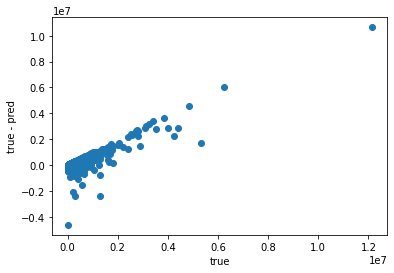

In [27]:
plt.scatter(test_y_true.numpy(), (test_y_true-test_y_pred).numpy())
plt.xlabel("true")
plt.ylabel("true - pred")
plt.show()

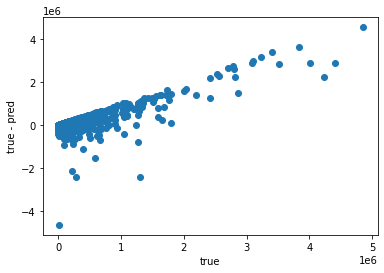

In [29]:
plt.scatter(test_y_true.numpy()[test_y_true<0.5*1e7], (test_y_true-test_y_pred).numpy()[test_y_true<0.5*1e7])
plt.xlabel("true")
plt.ylabel("true - pred")
plt.show()

In [ ]:
criterion(test_y_pred[test_y_true<0.5*1e7], test_y_true[test_y_true<0.5*1e7])

tensor(7.4653e+09)

In [ ]:
print(test_y_pred.numpy())

[11425.996  31686.963  11740.297  ...  3369.7847  6308.9126  4609.958 ]


In [ ]:
np.var(test_y_pred.numpy())

3.8146973e-06

In [ ]:
test_y_true.numpy().mean()

20547.762

In [38]:
np.var(test_y_pred.numpy())

3610341000.0

In [37]:
print(test_y_true.numpy())

[  19.707151 3543.0962   4783.       ...  415.       3557.
 9880.298   ]


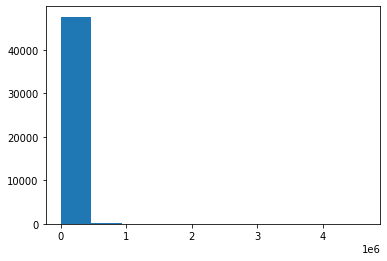

In [36]:
plt.hist(test_y_pred.numpy())
plt.show()

In [ ]:
test_y_pred.numpy()

array([17032.85, 17032.85, 17032.85, ..., 17032.85, 17032.85, 17032.85],
      dtype=float32)

In [ ]:
import pickle as pk

In [ ]:
pk.load(open("/content/drive/MyDrive/Project/KickLearning/data/texts_embedding/feature_names_for_inverse_transform.csv", "rb"))

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '00000000',
 '000000000001',
 '0000000168',
 '0000000516',
 '0000002100',
 '0000002117',
 '000000b',
 '000001',
 '000001s',
 '00000b',
 '00001',
 '000012',
 '000015',
 '00001in',
 '00003w',
 '00004',
 '00005in',
 '00005mm',
 '0000779fd2ac',
 '000078in',
 '00008',
 '00008412951a5d403bd1d',
 '00008mm',
 '0001',
 '00011',
 '000132',
 '00014',
 '00015',
 '0001in',
 '0002',
 '00023',
 '0002764217730854',
 '0002764217739660',
 '0002764218755835',
 '0002764218756921',
 '0002lb',
 '0003',
 '00031',
 '000393',
 '0003mm',
 '0004',
 '0004080c',
 '000478ed33343c7b820c0',
 '000490',
 '0004bsra',
 '0005',
 '0005in',
 '0006',
 '0007',
 '00070',
 '000704303',
 '00078',
 '0008',
 '0009',
 '000achiev',
 '000and',
 '000aud',
 '000bc',
 '000becaus',
 '000cad',
 '000can',
 '000cdn',
 '000chf',
 '000chfr',
 '000color',
 '000dkk',
 '000doubl',
 '000eleph',
 '000eur',
 '000euro',
 '000everi',
 '000flight',
 '000for',
 '000fps',
 '000ft',
 '000fund',
 '000fundinggo